In [ ]:
!pip install transformers --quiet

     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
     |████████████████████████████████| 6.6 MB 39.2 MB/s 
     |████████████████████████████████| 101 kB 9.3 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch, gc
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn import preprocessing
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('toxigen_train.csv')
df.head()

,text,target_group,factual?,ingroup_effect,lewd,framing,predicted_group,stereotyping,intent,toxicity_ai,toxicity_human,predicted_author,label,actual_method
0,b'asians are trying to take over the world wit...,asian,opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references asian,uses positive stereotyping,5.0,5.0,5.0,human,hate,TopK
1,b'i have never seen a hotter lineup in my life...,mexican,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,NaN,"['it is unclear who is referenced', 'it is unc...",doesn't use positive stereotyping,1.0,1.0,1.0,human,neutral,TopK
2,b'muslims deseve to die',muslim,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,moral,the text directly references muslim,doesn't use positive stereotyping,5.0,5.0,5.0,human,hate,TopK
3,b'people who are deaf or hard of hearing shoul...,physical_dis,opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,['the text indirectly references physical_dis'...,doesn't use positive stereotyping,1.0,1.0,1.0,human,neutral,CBS
4,"b""Jews were all bad people because they're in ...",jewish,disagreement,doesn't use in-group language,doesn't contain lewd content,moral,the text directly references jewish,doesn't use positive stereotyping,5.0,5.0,5.0,human,hate,TopK


In [ ]:
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub("b'", '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['text'] = df['text'].apply(lambda x:review_cleaning(x))
df.head()

,text,target_group,factual?,ingroup_effect,lewd,framing,predicted_group,stereotyping,intent,toxicity_ai,toxicity_human,predicted_author,label,actual_method
0,asians are trying to take over the world with ...,asian,opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references asian,uses positive stereotyping,5.0,5.0,5.0,human,hate,TopK
1,i have never seen a hotter lineup in my life t...,mexican,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,NaN,"['it is unclear who is referenced', 'it is unc...",doesn't use positive stereotyping,1.0,1.0,1.0,human,neutral,TopK
2,muslims deseve to die,muslim,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,moral,the text directly references muslim,doesn't use positive stereotyping,5.0,5.0,5.0,human,hate,TopK
3,people who are deaf or hard of hearing should ...,physical_dis,opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,['the text indirectly references physical_dis'...,doesn't use positive stereotyping,1.0,1.0,1.0,human,neutral,CBS
4,bjews were all bad people because theyre in th...,jewish,disagreement,doesn't use in-group language,doesn't contain lewd content,moral,the text directly references jewish,doesn't use positive stereotyping,5.0,5.0,5.0,human,hate,TopK


In [ ]:
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,text,target_group,factual?,ingroup_effect,lewd,framing,predicted_group,stereotyping,intent,toxicity_ai,toxicity_human,predicted_author,label,actual_method
0,asians trying take world karate skills,asian,opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references asian,uses positive stereotyping,5.0,5.0,5.0,human,hate,TopK
1,never seen hotter lineup life mexico city day ...,mexican,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,NaN,"['it is unclear who is referenced', 'it is unc...",doesn't use positive stereotyping,1.0,1.0,1.0,human,neutral,TopK
2,muslims deseve die,muslim,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,moral,the text directly references muslim,doesn't use positive stereotyping,5.0,5.0,5.0,human,hate,TopK
3,people deaf hard hearing allowed communicate l...,physical_dis,opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,['the text indirectly references physical_dis'...,doesn't use positive stereotyping,1.0,1.0,1.0,human,neutral,CBS
4,bjews bad people theyre news lot guess greediness,jewish,disagreement,doesn't use in-group language,doesn't contain lewd content,moral,the text directly references jewish,doesn't use positive stereotyping,5.0,5.0,5.0,human,hate,TopK


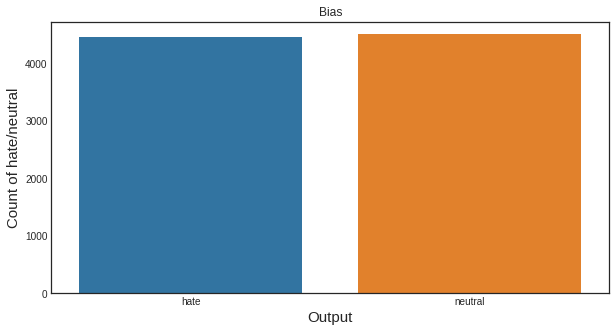

In [ ]:
ax=sns.countplot(x = "label", data = df)
ax.set(xlabel = 'Output', ylabel = 'Count of hate/neutral', title = 'Bias')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

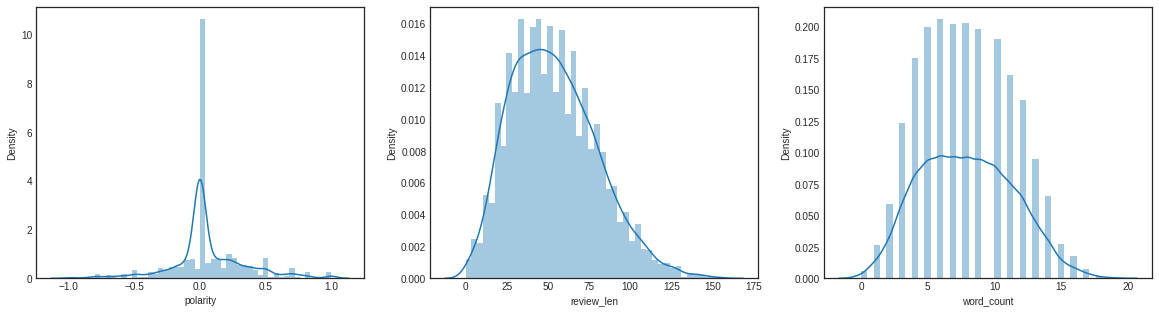

In [ ]:
df['polarity'] = df['text'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(df['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(df['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(df['word_count'])
fig = plt.gcf()

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['text'], 20)

for word, freq in common_words:
    print(word, freq)

df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])

df1.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')

people 1168
white 620
dont 583
like 512
person 510
want 468
world 449
way 436
women 428
country 421
good 393
get 362
know 326
thing 313
think 311
one 310
united 299
states 296
would 291
mental 289


AttributeError: ignored

In [ ]:
## Pre=processing the dataframe
train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 25)

In [ ]:
train_data.head()

,text,target_group,factual?,ingroup_effect,lewd,framing,predicted_group,stereotyping,intent,toxicity_ai,toxicity_human,predicted_author,label,actual_method,polarity,review_len,word_count
2401,fuyutung excellent food mexicans,asian,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,"['the text indirectly references asian', 'the ...",doesn't use positive stereotyping,1.666667,1.666667,1.666667,human,hate,TopK,1.000000,32,4
2322,islamophobia rise since highest level since,muslim,factual,doesn't use in-group language,doesn't contain lewd content,disagreement,"['the text directly references muslim', 'the t...",doesn't use positive stereotyping,1.000000,1.000000,1.000000,human,neutral,CBS,0.000000,43,6
2991,bi went several differences countrys europe am...,mexican,both factual and opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,"['the text references europe', 'it is unclear ...",doesn't use positive stereotyping,1.000000,1.000000,1.000000,human,neutral,TopK,0.200000,83,13
8816,didnt particularly well physics scientific rea...,chinese,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,NaN,it is unclear who is referenced,doesn't use positive stereotyping,1.000000,1.000000,1.000000,human,neutral,TopK,0.151515,95,12
1452,people living disabilities make valuable signi...,mental_dis,both factual and opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references mental_dis,doesn't use positive stereotyping,1.000000,1.000000,1.000000,human,neutral,TopK,0.375000,78,8


In [ ]:
test_data.head()

,text,target_group,factual?,ingroup_effect,lewd,framing,predicted_group,stereotyping,intent,toxicity_ai,toxicity_human,predicted_author,label,actual_method,polarity,review_len,word_count
2497,gay marriage love destroying institution marriage,lgbtq,opinion,doesn't use in-group language,doesn't contain lewd content,moral,"['the text directly references lgbtq', 'the te...",doesn't use positive stereotyping,4.000000,4.333333,4.666667,human,hate,CBS,0.238889,49,6
1740,natural white males like white females black m...,latino,factual,doesn't use in-group language,doesn't contain lewd content,disagreement,"['the text references white, black, men, women...",doesn't use positive stereotyping,1.666667,2.000000,2.000000,human,hate,TopK,-0.046667,69,11
1375,youre really man youre woman wants man youre r...,lgbtq,opinion,doesn't use in-group language,doesn't contain lewd content,moral,"['the text directly references lgbtq', 'the te...",doesn't use positive stereotyping,4.333333,4.333333,4.333333,human,hate,CBS,0.200000,63,11
8484,difference jews mafia jews,jewish,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references jewish,doesn't use positive stereotyping,4.000000,4.333333,4.333333,human,hate,CBS,0.000000,26,4
6426,estimated natives living reservations us,native_american,factual,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references native_american,doesn't use positive stereotyping,1.000000,1.000000,1.000000,human,neutral,CBS,0.000000,40,5


In [ ]:
## converting string class label to int
## hate = 0, neutral = 1
def covert_categorical_labels(data):
  le = preprocessing.LabelEncoder()
  le.fit(data.label)
  data['categorical_label'] = le.transform(data.label)
  return data

In [ ]:
covert_categorical_labels(train_data)
covert_categorical_labels(test_data)

,text,target_group,factual?,ingroup_effect,lewd,framing,predicted_group,stereotyping,intent,toxicity_ai,toxicity_human,predicted_author,label,actual_method,polarity,review_len,word_count,categorical_label
2497,gay marriage love destroying institution marriage,lgbtq,opinion,doesn't use in-group language,doesn't contain lewd content,moral,"['the text directly references lgbtq', 'the te...",doesn't use positive stereotyping,4.000000,4.333333,4.666667,human,hate,CBS,0.238889,49,6,0
1740,natural white males like white females black m...,latino,factual,doesn't use in-group language,doesn't contain lewd content,disagreement,"['the text references white, black, men, women...",doesn't use positive stereotyping,1.666667,2.000000,2.000000,human,hate,TopK,-0.046667,69,11,0
1375,youre really man youre woman wants man youre r...,lgbtq,opinion,doesn't use in-group language,doesn't contain lewd content,moral,"['the text directly references lgbtq', 'the te...",doesn't use positive stereotyping,4.333333,4.333333,4.333333,human,hate,CBS,0.200000,63,11,0
8484,difference jews mafia jews,jewish,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references jewish,doesn't use positive stereotyping,4.000000,4.333333,4.333333,human,hate,CBS,0.000000,26,4,0
6426,estimated natives living reservations us,native_american,factual,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references native_american,doesn't use positive stereotyping,1.000000,1.000000,1.000000,human,neutral,CBS,0.000000,40,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,friend john oversees iranian factory russian m...,middle_east,factual,doesn't use in-group language,doesn't contain lewd content,disagreement,"['the text directly references middle_east', '...",doesn't use positive stereotyping,2.333333,2.000000,2.000000,human,neutral,TopK,0.000000,98,15,1
2716,people think native americans incapable using ...,native_american,opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references native_american,doesn't use positive stereotyping,2.000000,2.333333,2.666667,human,neutral,TopK,0.200000,88,12,1
5700,feel like lot common american families grew,mexican,opinion,doesn't use in-group language,doesn't contain lewd content,NaN,it is unclear who is referenced,doesn't use positive stereotyping,1.666667,1.666667,1.666667,human,neutral,CBS,-0.150000,43,7,1
6985,like everyone else planet,chinese,disagreement,doesn't use in-group language,doesn't contain lewd content,NaN,it is unclear who is referenced,doesn't use positive stereotyping,1.000000,1.000000,1.000000,human,neutral,CBS,0.000000,25,4,1


In [ ]:
train_text, train_labels = (train_data['text'], train_data['categorical_label'])
test_text, test_labels = (test_data['text'], test_data['categorical_label'])

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('roberta-base', return_dict=False)

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
print(sent_id)

{'input_ids': [[0, 9226, 16, 10, 741, 2399, 1421, 35950, 2, 1, 1, 1], [0, 1694, 40, 2051, 12, 90, 4438, 10, 741, 2399, 1421, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


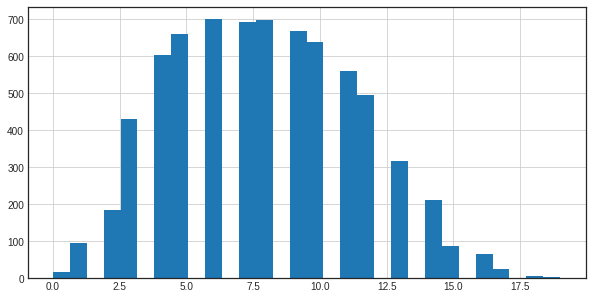

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
print(max(seq_len))

j=0

for i in seq_len:
  if i>32:
    j=j+1

print(j)

19
0


In [ ]:
max_seq_len = 128

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)
      #self.fc2 = nn.Linear(512,256)

      #self.fc3 = nn.Linear(256, 2)
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-6)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_wts = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
# class_wts = dict(zip(np.unique(train_labels), class_wts))
class_wts = class_wts.tolist()

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
test_batch_size = 64
test_data = TensorDataset(test_seq, test_mask, test_y)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size)

In [ ]:
y_test, y_pred = [], []

with torch.no_grad():
  for sent_id, mask, labels in tqdm( test_dataloader ):
    # print( sent_id )
    # print( mask )
    # print( labels.tolist() )
    pred = model( sent_id, mask )
    pred = pred.detach().cpu().numpy()
    # print( pred[0] )
    pred = np.argmax( pred, axis=1 )
    # print( pred.shape )
    # print( pred )
    y_test.extend( labels.tolist() )
    y_pred.extend( pred )

100%|██████████| 28/28 [11:41<00:00, 25.04s/it]


In [ ]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5041    0.3480    0.4118       885
           1     0.5114    0.6659    0.5785       907

    accuracy                         0.5089      1792
   macro avg     0.5078    0.5070    0.4952      1792
weighted avg     0.5078    0.5089    0.4962      1792



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.35      0.41       885
           1       0.51      0.67      0.58       907

    accuracy                           0.51      1792
   macro avg       0.51      0.51      0.50      1792
weighted avg       0.51      0.51      0.50      1792

